# Assignment 4

1. 請找出`dcard-top100.csv`中所有的的subject-predicate組合並透過network-x以graph呈現。

- subject-predicate pair: `我 喜歡`，`他 發現`, `你 看到`

- 為了簡化問題，你可以選擇直接使用spacy dependency parser中的`nsubj`token及其head text當作subject-predicate pairs。但你也可以以自己的方式（不一定要用spacy）找出subject-predicate pairs。

- 請以每個subject-predicate pair**出現的次數**當作每個pair的weights，並呈現在一個dataframe中。請只納入**出現2次以上**的pair.
- 最後請利用network-x畫出subject-predicate詞彙網絡：edge由subject指向predicate，而箭頭的粗細則代表一個pair在語料中出現次數(weights)

2. 請利用node2vec找出第一小題中每個predicate node的node vector並作圖呈現。
- 只需要找出你的圖中predicate的node vector即可
- 將所有predicate畫成平面scatter plot (參考範例輸出)

================================

你的output至少需要包含：

1. Subject-predicate-weights dataframe (10%)
2. Subject-predicate graph (40%)
3. Predicate node embedding matrix (10%)
4. Predicate node embedding scatterplot (40%)

# 0. Import data

In [1]:
import pandas as pd

In [2]:
#讓networkx能顯示中文
#跑完這格重啟執行階段即可
!mv SimHei.ttf /usr/local/lib/python3.7/dist-packages/matplotlib//mpl-data/fonts/ttf
!rm -fr ~/.cache/matplotlib

mv: cannot stat 'SimHei.ttf': No such file or directory


In [3]:
from google.colab import drive
drive.mount('/content/drive')

!wget -P /content/drive/MyDrive/NTU_Studies/2021_Fall

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
wget: missing URL
Usage: wget [OPTION]... [URL]...

Try `wget --help' for more options.


# 1. Subject-predicate graph

## Subject-predicate-weights dataframe

In [4]:
dcard100 = '/content/drive/MyDrive/NTU_Studies/2021_Fall/assignment-4-tanlianhui/dcard-top100.csv'
dcard = pd.read_csv(dcard100).dropna()

In [5]:
!pip install -U spacy
!python -m spacy download zh_core_web_lg

     |████████████████████████████████| 603.9 MB 21 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('zh_core_web_lg')


In [6]:
import spacy
nlp = spacy.load("zh_core_web_lg")
import re

df = []
iter_dcard = dcard[['title']].values.tolist() + dcard[['content']].values.tolist()
for i in iter_dcard:
    ## data cleaning
    content = ' '.join(str(e) for e in i)
    content = re.sub("[^\u4e00-\u9fff\r\n0-9 ，。]", "", content)
    content = re.sub("[\r\n ，。]", "\u3000", content)
    content = list(filter(None, content.split('\u3000')))
    # print(content)

    for j in content:
        # print(j)
        doc = nlp(j)
        subj_pred_pair = []
        for token in doc:
            # print(token.dep_) 
            if token.dep_ == 'nsubj':
                # print(token.text, token.dep_)
                subj_pred_pair.append(token.text)
            if token.dep_ == 'ROOT':
                # print(token.text, token.dep_)
                subj_pred_pair.append(token.head.text)
                if len(subj_pred_pair) == 2:
                    df.append(subj_pred_pair)
                    break

In [7]:
print(len(df))
print(df[0:10])

1821
[['我', '燒死'], ['泳衣', '怪嗎'], ['你', '嗎'], ['發胖', '開學'], ['我', '談戀'], ['女孩', '懲罰'], ['偶像', '抓到'], ['悲劇', '發生'], ['對象', '傳'], ['聖圭', '確定']]


In [8]:
df = pd.DataFrame(df, columns = ['subject', 'predicate'])
weights_df = df.groupby(["subject", "predicate"]).size().rename('weights')
df = df.join(weights_df, on=["subject", "predicate"])
# print(df)
sub_pred_df = df[df.weights > 1].sort_values(by = ['weights', 'subject'], ascending = False)
# print(sp_df)

sub_pred_df = sub_pred_df.drop_duplicates().reset_index()
sub_pred_df = sub_pred_df.drop('index', 1)
# print(sub_pred_df)

In [9]:
sub_pred_df

,subject,predicate,weights
0,我,想,16
1,我,有,10
2,小天,使,10
3,我,知道,9
4,我,看,8
...,...,...,...
94,他,傳,2
95,他,打開,2
96,他,想要,2
97,他,相信,2


## Subject-predicate graph

In [10]:
import networkx as nx
G = nx.DiGraph()
G.add_nodes_from(sub_pred_df.subject)
G.add_nodes_from(sub_pred_df.predicate)

for idx, row in sub_pred_df.iterrows():
    # print(row['subject'], row['predicate'], row['weights'])
    G.add_edges_from([(row['subject'], row['predicate'], {'distance':row['weights']})])

In [11]:
from matplotlib import font_manager

!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

font_dirs = ["/content"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

import matplotlib.pyplot as plt
plt.rc('font', family='Taipei Sans TC Beta')

--2021-11-24 08:45:44--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 209.85.145.102, 209.85.145.101, 209.85.145.100, ...
Connecting to drive.google.com (drive.google.com)|209.85.145.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/i2ab7bod0cppce9l5sblc8mr0o4u0r07/1637743500000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2021-11-24 08:45:44--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/i2ab7bod0cppce9l5sblc8mr0o4u0r07/1637743500000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 142.250.152.132, 2607:f8b0:4001:c56::84
Connecting to doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)|142.2

In [12]:
## ref: https://stackoverflow.com/questions/52400380/assign-edge-weights-to-a-networkx-graph-using-pandas-dataframe
# import matplotlib.pyplot as plt
# import matplotlib.font_manager as fm
# prop = fm.FontProperties(fname='/content/drive/MyDrive/NTU_Studies/2021_Fall/python-warmup-exercise-tanlianhui/SimHei.ttf')
# fontproperties = prop

def plot_graph(G):
    weight_ls = []
    for j in dict(G.edges).values():
        for k in j.values():
            weight_ls.append(float(k))

    # weights = [i['weights']/5 for i in dict(G.edges).values()]
    weights = [i/5 for i in weight_ls]
    fig, ax = plt.subplots(figsize = (20,10))
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, ax = ax, node_color = 'pink', node_size = 400)
    nx.draw_networkx_edges(G, pos, width = weights, ax = ax)
    _ = nx.draw_networkx_labels(G, pos, ax = ax, font_family = 'SimHei')

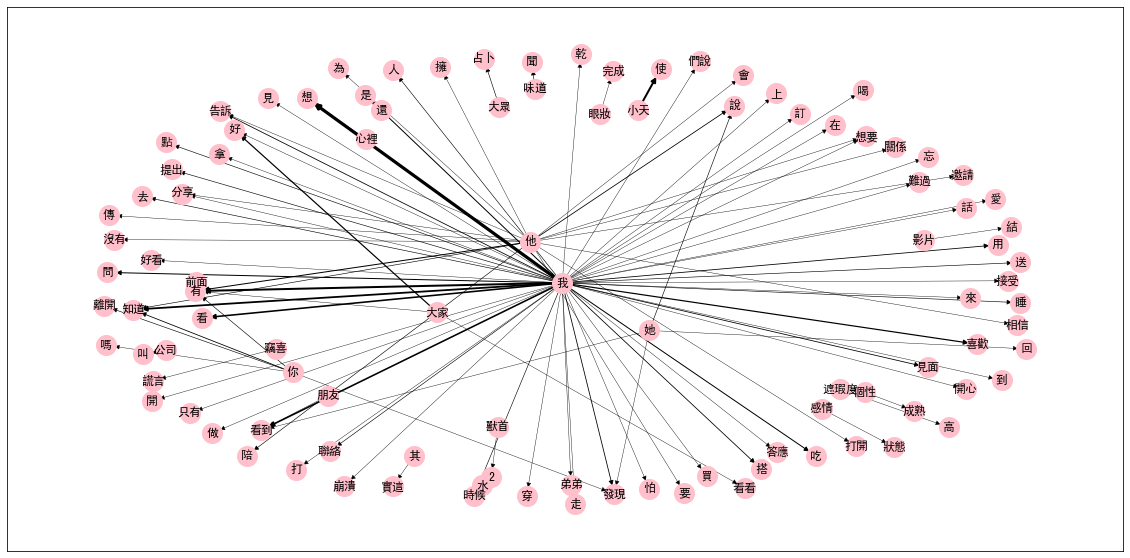

In [13]:
plot_graph(G)

# 2. Predicate node embeddings
請利用node2vec找出第一小題中每個predicate node的node vector並作圖呈現。
只需要找出你的圖中predicate的node vector即可
將所有predicate畫成平面scatter plot (參考範例輸出)

In [14]:
!pip install --user --upgrade gensim
import gensim
!pip install --user --upgrade node2vec
from node2vec import Node2Vec

In [22]:
node2vec = Node2Vec(G, dimensions = 20, walk_length = 16, num_walks = 100, workers = 2)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities:   0%|          | 0/103 [00:00<?, ?it/s]

In [60]:
import numpy
embeddings_ls = []
idx = []

for i in range(len(sub_pred_df)):
    pred = sub_pred_df['predicate'][i]
    if pred in model.wv:
        embed = model.wv[pred]
        idx.append(pred)
        embeddings_ls.append(embed)
# print(embeddings_ls)
df1 = pd.DataFrame(idx)
df1.columns = ['predicate']
df2 = pd.DataFrame(embeddings_ls)
df_inner = df1.merge(df2, how='inner', left_index=True, right_index=True)
vec_matrix = df_inner.set_index('predicate')

In [61]:
vec_matrix

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
predicate,,,,,,,,,,,,,,,,,,,,
想,-0.011661,0.000463,-0.020010,-0.037834,-0.003483,0.014079,-0.002374,0.035921,-0.011962,0.012906,0.036323,0.040794,-0.004811,-0.050325,0.026743,0.003686,0.047314,-0.000372,-0.017347,-0.049614
有,0.035208,0.031409,0.041615,0.012232,0.040379,-0.014912,0.000547,0.041770,-0.038485,-0.020664,-0.033035,-0.010742,0.056915,-0.041329,-0.005235,-0.008969,0.056605,-0.025367,-0.002769,-0.030729
使,0.010168,-0.025058,0.046923,-0.050758,0.042362,0.019637,-0.023205,0.028448,-0.006561,0.037388,0.060365,-0.029860,0.000815,-0.031904,0.025830,0.020329,0.047474,0.037712,0.050136,0.050523
知道,0.000375,0.025454,0.041561,-0.002985,0.024849,-0.029893,-0.000450,0.046611,-0.012000,-0.050018,0.031838,-0.023245,-0.002571,0.049046,-0.007913,-0.022057,-0.021707,0.037893,-0.031969,0.007489
看,0.003823,0.022128,-0.025446,-0.010574,0.040556,-0.021089,-0.038153,0.046367,-0.010740,-0.023596,0.042945,0.021293,0.021604,0.046335,-0.042231,0.026286,0.010362,0.020943,0.008391,0.022275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
傳,0.042211,-0.003001,0.046212,-0.040484,0.018741,0.013362,0.003976,0.012576,-0.037605,-0.046861,0.011792,0.029661,0.041192,0.028828,-0.003449,0.042165,-0.045446,0.017136,0.000546,0.018518
打開,0.030675,-0.032341,-0.033537,0.012833,-0.007969,-0.030245,0.047664,-0.025329,-0.033162,-0.001014,-0.013370,0.001743,-0.017330,-0.001801,-0.003417,0.004424,0.041831,-0.028083,-0.008409,0.028143
想要,0.036505,-0.033516,0.028715,-0.047118,-0.003699,-0.043334,-0.025036,0.047113,-0.009344,0.014422,0.046044,0.043966,-0.040500,-0.015100,0.049741,0.025749,-0.007073,-0.042627,0.014594,-0.033925


In [70]:
# PCA to two dimensions
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_matrix = pca.fit(vec_matrix).transform(vec_matrix)
pca_df = pd.DataFrame(pca_matrix)
pca_df = pca_df.set_axis(["X", "Y"], axis=1)
pca_df.index = vec_matrix.index.to_list()
pca_df

,X,Y
想,0.005741,0.021294
有,-0.076212,0.030156
使,-0.001356,-0.029578
知道,-0.043594,-0.017816
看,-0.006496,-0.047599
...,...,...
傳,-0.030226,-0.074158
打開,-0.003580,0.004076
想要,0.007846,-0.018706
相信,0.032800,0.007479


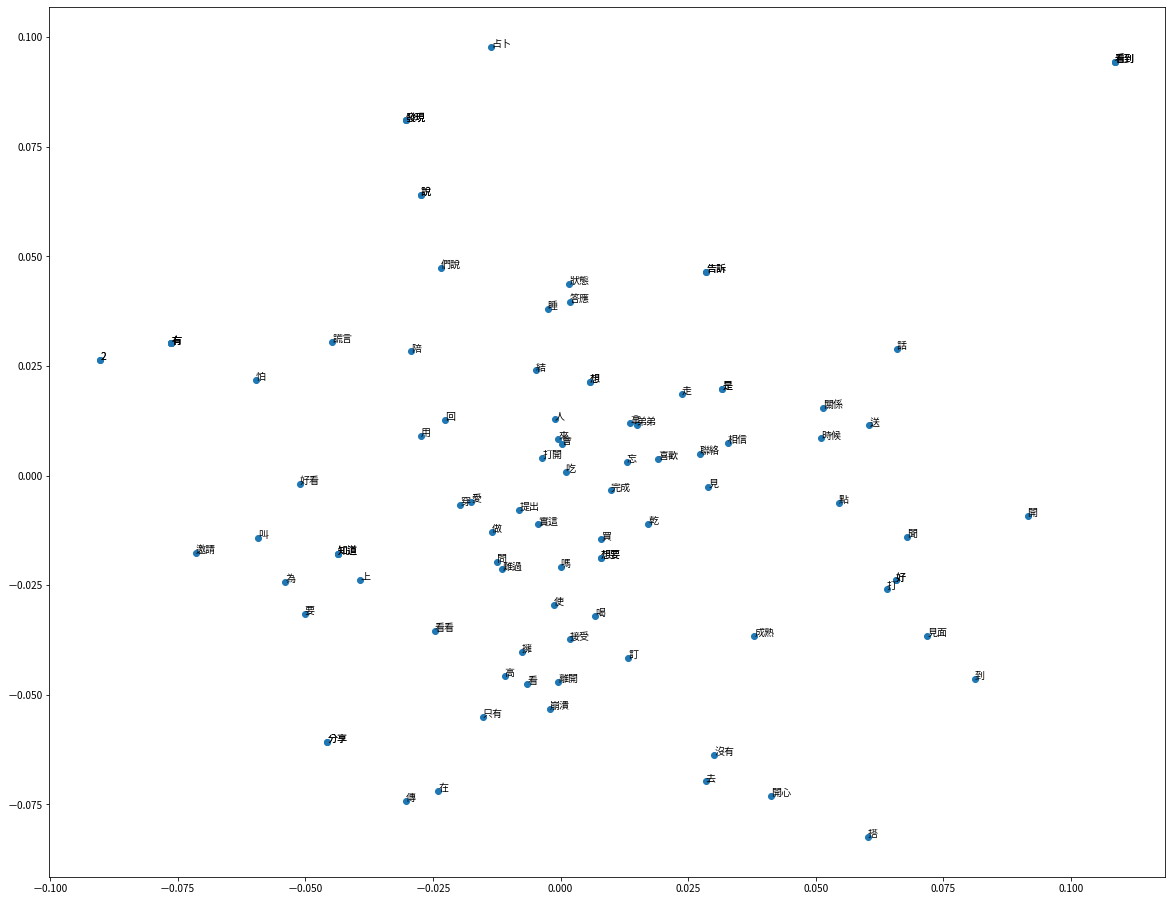

In [84]:
plt.figure(figsize = (20,16)) 
plt.scatter(pca_df["X"], pca_df["Y"])
for i, label in enumerate(vec_matrix.index.to_list()):
    plt.annotate(label, (pca_df["X"][i], pca_df["Y"][i]))
plt.show()